In [1]:
import sys
sys.path.append('..')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import logging
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt

from ase import Atoms
from ase.io import read

from m_ff.configurations import carve_confs
from m_ff.models import TwoBodySingleSpeciesModel, ThreeBodySingleSpeciesModel, CombinedSingleSpeciesModel
from m_ff.calculators import TwoBodySingleSpecies, ThreeBodySingleSpecies, CombinedSingleSpecies

logging.basicConfig(level=logging.INFO)

## Parameters

In [2]:
# Parameters
directory = Path('data/Fe_grain_001/')
r_cut = 3.4
sigma_2b = 0.3
sigma_3b = 0.6
noise = 0.00000001

# GP Parameters
ntr = 300
ntest = 100
combine_2b_3b = True

# mapping
grid_start = 2.0
num_2b = 100
num_3b = 50

In [3]:
# # ----------------------------------------
# # Construct a configuration database
# # ----------------------------------------
n_data = 5000

filename = directory / 'dft_all_snapshots.xyz'

traj = read(filename, index=slice(None), format='extxyz')

In [4]:
elements, confs, forces, energies = carve_confs(
    traj, r_cut, n_data,
    forces_label='forces')

if not os.path.exists(directory):
    os.makedirs(directory)

np.save('{}/confs_cut={:.2f}.npy'.format(directory, r_cut), confs)
np.save('{}/forces_cut={:.2f}.npy'.format(directory, r_cut), forces)

lens = [len(conf) for conf in confs]

logging.info('\n'.join((
    'Number of atoms in a configuration:',
    '   maximum: {}'.format(np.max(lens)),
    '   minimum: {}'.format(np.min(lens)),
    '   average: {:.4}'.format(np.mean(lens))
)))

INFO:root:Reading traj step 0
INFO:root:Reading traj step 1
INFO:root:Reading traj step 2
INFO:root:Reading traj step 3


Settin n_data = 3840


INFO:root:Number of atoms in a configuration:
   maximum: 16
   minimum: 12
   average: 13.81


M is 13.808854166666666 += 0.3858591037326562


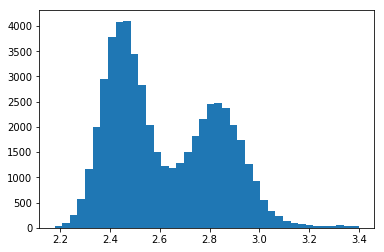

In [5]:
confs = np.load(str(directory) + '/confs_cut={:.2f}.npy'.format(r_cut))

distances = []
M_mean = 0.
M_std = 0.
for c in confs:
    distances += np.linalg.norm(c[:, 0:3], axis=1).tolist()
    M_mean += c.shape[0]
    M_std += c.shape[0] ** 2

M_mean = M_mean / len(confs)
M_std = M_std / len(confs) - M_mean ** 2
print('M is {} += {}'.format(M_mean, M_std))
plt.hist(distances, 40)
plt.show()

In [6]:
# Get configurations and forces from file
confs = np.load(directory / 'confs_cut={:.2f}.npy'.format(r_cut))
forces = np.load(directory / 'forces_cut={:.2f}.npy'.format(r_cut))

numconfs = len(forces)
ind = np.arange(numconfs)
ind_tot = np.random.choice(ind, size=ntr + ntest, replace=False)

# Use fixed training and testing dataset
tr_confs, tr_forces = confs[ind_tot[:ntr]], forces[ind_tot[:ntr]]
tst_confs, tst_forces = confs[ind_tot[ntr:]], forces[ind_tot[ntr:]]

## GP - 2+3Body

In [7]:
model_3b = CombinedSingleSpeciesModel(elements[0], r_cut, sigma_2b, sigma_3b, r_cut / 10.0, r_cut / 10.0, noise)
model_3b.fit(tr_confs, tr_forces)

INFO:m_ff.kernels.twobody:Started compilation of theano two body single species kernels
INFO:m_ff.kernels.twobody:Ended compilation of theano two body single species kernels
INFO:m_ff.kernels.threebodykernel:Started compilation of theano three body kernels
INFO:m_ff.kernels.threebodykernel:Ended compilation of theano three body kernels


In [8]:
# Test the GP performance
print('Testing GP')

gp_forces = np.zeros((ntest, 3))

for i in np.arange(ntest):
    gp_forces[i] = model_3b.predict(np.reshape(tst_confs[i], (1, len(tst_confs[i]), 5)))   
    
gp_error = gp_forces - tst_forces

MAE = np.mean(np.abs(gp_error))
SMAE = np.std(np.abs(gp_error))

print('MAE on training set  forces: {:.4f} +- {:.4f}'.format(MAE, SMAE))

Testing GP
MAE on training set  forces: 0.0742 +- 0.0854


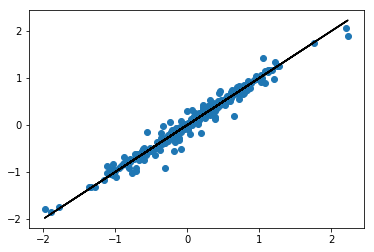

In [9]:
plt.scatter(tst_forces, gp_forces)
plt.plot(tst_forces, tst_forces, 'k-')
plt.show()

In [10]:
model_3b.build_grid(grid_start, num_2b, num_3b)

In [11]:
calc = CombinedSingleSpecies(r_cut, model_3b.grid[(26, 26)], model_3b.grid[(26, 26, 26)])

In [18]:

from ase.calculators.emt import EMT
from ase.dft.kpoints import ibz_points, bandpath
from ase.phonons import Phonons

# Setup crystal and EMT calculator
# atoms = bulk('Si', 'diamond', a=5.39760794)
atoms = bulk('Fe', 'bcc', a=2.856, cubic=True)
np.sqrt(np.sum(np.square(atoms.get_positions()[1])))

2.4733685532083567

In [19]:
# Phonon calculator
N = 7
ph = Phonons(atoms, calc, supercell=(N, N, N), delta=0.003)
ph.run()

INFO:m_ff.calculators:numbers is in system_changes
INFO:m_ff.calculators:initialize


Writing phonon.eq.pckl
Writing phonon.0x-.pckl
Writing phonon.0x+.pckl
Writing phonon.0y-.pckl
Writing phonon.0y+.pckl
Writing phonon.0z-.pckl
Writing phonon.0z+.pckl
Writing phonon.1x-.pckl
Writing phonon.1x+.pckl
Writing phonon.1y-.pckl
Writing phonon.1y+.pckl
Writing phonon.1z-.pckl
Writing phonon.1z+.pckl


In [20]:
# Read forces and assemble the dynamical matrix
ph.read(acoustic=True)

# High-symmetry points in the Brillouin zone
points = ibz_points['fcc']
G = points['Gamma']
X = points['X']
W = points['W']
K = points['K']
L = points['L']
U = points['U']

point_names = ['$\Gamma$', 'X', 'U', 'L', '$\Gamma$', 'K']
path = [G, X, U, L, G, K]

# Band structure in meV
path_kc, q, Q = bandpath(path, atoms.cell, 100)
omega_kn = 1000 * ph.band_structure(path_kc)

# Calculate phonon DOS
omega_e, dos_e = ph.dos(kpts=(50, 50, 50), npts=5000, delta=5e-4)
omega_e *= 1000

WARNING, 2 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 6.619e-09*i)
WARNING, 2 imaginary frequencies at q = ( 0.00,  0.00,  0.00) ; (omega_q = 6.619e-09*i)


/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


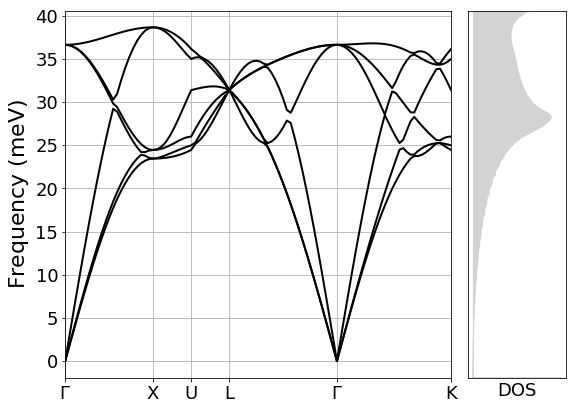

In [17]:
# Plot the band structure and DOS
import matplotlib.pyplot as plt
plt.figure(1, (8, 6))
plt.axes([.1, .07, .67, .85])
for n in range(len(omega_kn[0])):
    omega_n = omega_kn[:, n]
    plt.plot(q, omega_n, 'k-', lw=2)
    
plt.xticks(Q, point_names, fontsize=18)

plt.yticks(fontsize=18)
plt.xlim(q[0], q[-1])
plt.ylabel("Frequency ($\mathrm{meV}$)", fontsize=22)
plt.grid('on')

plt.axes([.8, .07, .17, .85])
plt.fill_between(dos_e, omega_e, y2=0, color='lightgrey', edgecolor='k', lw=1)
plt.ylim(0, 35)
plt.xticks([], [])
plt.yticks([], [])
plt.xlabel("DOS", fontsize=18)
plt.show()